In [1]:
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import scipy.sparse as sp
import os
from datetime import datetime, timedelta
from torch_geometric.utils import from_scipy_sparse_matrix
from matplotlib.lines import Line2D

In [2]:
step_minutes = 5

history_len = 12 # THIS DOES NOT CHANGE
future_len = 3 # THIS CHANGES!!!!!!!!!
window_len = history_len + future_len

In [3]:
pems7d_data_per_step_short = 70
pems7d_data_per_step_long = 140

pems7d_initial_train_len = 4537
pems7d_train_len = 10137
pems7d_valid_len = 2534
pems7d_total_len = pems7d_train_len + pems7d_valid_len

pems7d_start_datetime = datetime.strptime("01.05.2012 00:00", "%d.%m.%Y %H:%M") # pems7d - 01.05.2012. - 30.06.2012.

In [4]:
pemsbay_data_per_step_short = 70
pemsbay_data_per_step_long = 140

pemsbay_initial_train_len = 29692
pemsbay_train_len = 41692
pemsbay_valid_len = 10423
pemsbay_total_len = pemsbay_train_len + pemsbay_valid_len

pemsbay_start_datetime = datetime.strptime("01.01.2017 00:00", "%d.%m.%Y %H:%M") # pemsbay - 01.01.2017. - 30.06.2017.

In [5]:
def epoch_to_datetime_pems7d(epoch, data_per_step):
    """Convert epoch index (1-based) into datetime"""
    # initial training data is skipped
    base_minutes = pems7d_initial_train_len * step_minutes
    # each epoch after adds data_per_step * step_minutes
    minutes_after = epoch * data_per_step * step_minutes
    return pems7d_start_datetime + timedelta(minutes=base_minutes + minutes_after)

def epoch_to_datetime_pemsbay(epoch, data_per_step):
    """Convert epoch index (1-based) into datetime"""
    # initial training data is skipped
    base_minutes = pems7d_initial_train_len * step_minutes
    # each epoch after adds data_per_step * step_minutes
    minutes_after = epoch * data_per_step * step_minutes
    return pemsbay_start_datetime + timedelta(minutes=base_minutes + minutes_after)

In [6]:
def plot_pemsbay_short_vs_long_tripanel(
    short_experiments, long_experiments, short_info, long_info,
    cloudlets_human=[3, 4, 5, 7],
    comm_ylim=None, wmape_ylim=None, scsr_ylim=None,
    verbose_missing_cols=True,
    xpad_frac=0.04,
    figHeight = 22,
):
    import os
    import pandas as pd
    import matplotlib.pyplot as plt
    from matplotlib.ticker import FormatStrFormatter

    # ---------- helpers ----------
    def _normalize_label(lab: str) -> str:
        alias = {
            "Full graph connectivity": "Full cross-cloudlet connectivity",
            "No graph connectivity": "No cross-cloudlet nodes connectivity",
            "Node score algorithm": "Node score algorithm",
        }
        return alias.get(lab, lab)

    def _epoch_to_dt(e, dps):
        return epoch_to_datetime_pemsbay(e, int(dps))

    def _try_load_metric_csv(base_folder, cln_id, metric_kind):
        if metric_kind == "wmape":
            p = os.path.join(base_folder, f"val_metric/masked_{cln_id}.csv")
        else:  # scsr
            p = os.path.join(base_folder, f"new_val_metric/masked_{cln_id}.csv")
        if os.path.exists(p):
            df = pd.read_csv(p)
            # if "Epoch" in df.columns:
            #     df = df[df["Epoch"] != 0].reset_index(drop=True)
            return df
        return None

    def _find_col(df, options):
        # exact first
        for c in options:
            if c in df.columns:
                return c
        # CI contains fallback
        lower_map = {c.lower(): c for c in df.columns}
        for opt in options:
            opt_l = opt.lower()
            for lc, orig in lower_map.items():
                if opt_l in lc:
                    return orig
        return None

    # Column candidates
    SCSR_CANDIDATES = [
        "SCSR", "SCSR [%]", "SCSR (%)",
        "Total sudden change in speed rate",
        "Total sudden change in speed rate [%]",
        "Total sudden change in speed rate (%)",
        "Sudden change in speed rate",
        "Sudden change in speed rate [%]",
    ]
    WMAPE_CANDIDATES = [
        "WMAPE [%]", "WMAPE", "WMAPE(%)", "WMAPE (%)"
    ]
    SCSR_COUNT_COL = "Total sudden change in speed count"

    # ---------- unified colors (same per label across all subplots) ----------
    COLORS = {
        "Full cross-cloudlet connectivity": "C0",
        "Node score algorithm":             "C1",
        "No cross-cloudlet nodes connectivity": "C2",
    }

    # legend prototypes (one solid + one dashed per configuration)
    LEGEND_MAIN = {
        "Full cross-cloudlet connectivity": Line2D([0], [0], color=COLORS["Full cross-cloudlet connectivity"], linestyle='-'),
        "Node score algorithm":             Line2D([0], [0], color=COLORS["Node score algorithm"], linestyle='-'),
        "No cross-cloudlet nodes connectivity": Line2D([0], [0], color=COLORS["No cross-cloudlet nodes connectivity"], linestyle='-'),
    }
    LEGEND_AVG = {
        "Full cross-cloudlet connectivity": Line2D([0], [0], color=COLORS["Full cross-cloudlet connectivity"], linestyle=(0, (5, 5))),
        "Node score algorithm":             Line2D([0], [0], color=COLORS["Node score algorithm"], linestyle=(0, (5, 5))),
        "No cross-cloudlet nodes connectivity": Line2D([0], [0], color=COLORS["No cross-cloudlet nodes connectivity"], linestyle=(0, (5, 5))),
    }

    legend_handles = {}
    def _remember(handle_key, handle):
        if handle is not None:
            legend_handles[handle_key] = handle

    # ---------- plotting helpers ----------
    def _plot_comm(ax, exps, cln_id):
        for lbl, cfg in exps.items():
            n_lbl = _normalize_label(lbl)
            if n_lbl not in ("Full cross-cloudlet connectivity", "Node score algorithm"):
                continue  # comm only for these two
            csv_path = os.path.join(cfg["folder"], f"communication_size/{cln_id}_total_transfer_size_node_features.csv")
            if not os.path.exists(csv_path):
                continue
            df = pd.read_csv(csv_path)
            if "Epoch" in df.columns:
                df = df[df["Epoch"] != 0].reset_index(drop=True)
                dts = [_epoch_to_dt(e, cfg["data_per_step"]) for e in df["Epoch"]]
            else:
                dts = range(len(df))
            if "Megabytes" not in df.columns:
                if verbose_missing_cols:
                    print(f"[comm] Missing 'Megabytes' in {csv_path}")
                continue
            y = df["Megabytes"].astype(float)
            (h,) = ax.plot(
                dts, y,
                linestyle="-", marker=None,
                color=COLORS.get(n_lbl),
                label=f"{n_lbl} (Transfer)"
            )
            _remember(("comm", n_lbl), h)

    def _plot_metric(ax, exps, cln_id, metric_kind):
        for lbl, cfg in exps.items():
            n_lbl = _normalize_label(lbl)
            df = _try_load_metric_csv(cfg["folder"], cln_id, metric_kind)
            if df is None or "Epoch" not in df.columns:
                continue

            # For SCSR: filter out epochs with zero sudden-change count if present
            if metric_kind == "scsr" and SCSR_COUNT_COL in df.columns:
                mask = df[SCSR_COUNT_COL] > 0
                df = df.loc[mask].copy()
                if df.empty:
                    continue

            dts = [_epoch_to_dt(e, cfg["data_per_step"]) for e in df["Epoch"]]

            if metric_kind == "wmape":
                col = _find_col(df, WMAPE_CANDIDATES)
                if col is None:
                    if verbose_missing_cols:
                        print(f"[wmape] Missing WMAPE column in {cfg['folder']} / cloudlet {cln_id}")
                    continue
                y = df[col].astype(float)
                label = f"{n_lbl} WMAPE"
                key = ("wmape", n_lbl)

                # --- scale to % if data look like fractions
                if y.max() <= 1.0001:
                    y = y * 100.0

                dts = [_epoch_to_dt(e, cfg["data_per_step"]) for e in df["Epoch"]]
                (h,) = ax.plot(dts, y, linestyle="-", marker=None,
                            color=COLORS.get(n_lbl), label=f"{n_lbl} WMAPE")
                # dashed average spanning ONLY the data range
                y_mean = float(y.mean())
                # ax.hlines(y_mean, dts[0], dts[-1],
                #         colors=COLORS.get(n_lbl), linestyles=(0, (5, 5)))
                ax.axhline(
                    y_mean, xmin=0.0, xmax=1.0,
                    color=COLORS.get(n_lbl),
                    linestyle=(0, (5, 5)),
                    linewidth=1.6,       # or make this a parameter if you want
                    zorder=6,
                    clip_on=False
                )
                _remember(("wmape", n_lbl), h)
            else:  # scsr
                col = _find_col(df, SCSR_CANDIDATES)
                if col is None:
                    if verbose_missing_cols:
                        print(f"[scsr] Missing SCSR column in {cfg['folder']} / cloudlet {cln_id}")
                    continue
                y = df[col].astype(float)
                label = f"{n_lbl} SCSR"
                key = ("scsr", n_lbl)

                if y.max() <= 1.0001:
                    y = y * 100.0

                ts = [_epoch_to_dt(e, cfg["data_per_step"]) for e in df["Epoch"]]
                (h,) = ax.plot(dts, y, linestyle="-", marker=None,
                            color=COLORS.get(n_lbl), label=f"{n_lbl} SCSR")
                # dashed average spanning ONLY the data range (after filtering)
                y_mean = float(y.mean())
                # ax.hlines(y_mean, dts[0], dts[-1],
                #         colors=COLORS.get(n_lbl), linestyles=(0, (5, 5)))
                ax.axhline(
                    y_mean, xmin=0.0, xmax=1.0,
                    color=COLORS.get(n_lbl),
                    linestyle=(0, (5, 5)),
                    linewidth=1.6,
                    zorder=6,
                    clip_on=False
                )
                _remember(("scsr", n_lbl), h)

            (h,) = ax.plot(
                dts, y,
                linestyle="-", marker=None,   # solid lines everywhere
                color=COLORS.get(n_lbl),
                label=label
            )
            _remember(key, h)

    # ---------- layout ----------
    cloudlets_zero = [c - 1 for c in cloudlets_human]

    n_rows, n_cols = len(cloudlets_human), 2
    fig = plt.figure(figsize=(18, figHeight), constrained_layout=False)
    outer = fig.add_gridspec(nrows=n_rows, ncols=n_cols, wspace=0.10, hspace=0.16)

    last_row = n_rows - 1

    # ---------- build panels ----------
    for r, (cln_h, cln_z) in enumerate(zip(cloudlets_human, cloudlets_zero)):
        for c in range(n_cols):
            is_short = (c == 0)
            exps = short_experiments if is_short else long_experiments

            trip = outer[r, c].subgridspec(3, 1, hspace=0.0)  # touching
            ax_comm  = fig.add_subplot(trip[0, 0])
            ax_wmape = fig.add_subplot(trip[1, 0], sharex=ax_comm)
            ax_scsr  = fig.add_subplot(trip[2, 0], sharex=ax_comm)

            # COMM
            _plot_comm(ax_comm, exps, cln_z)
            ax_comm.grid(True, alpha=0.3)
            ax_comm.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            if comm_ylim is not None: ax_comm.set_ylim(*comm_ylim)
            if c == 0: ax_comm.set_ylabel("Transfer (MB)")
            else:      ax_comm.tick_params(labelleft=False)
            ax_comm.get_xaxis().set_visible(False)
            ax_comm.set_title(f"Cloudlet {cln_h} — {'Short-term' if is_short else 'Long-term'}", fontsize=10)

            # WMAPE
            _plot_metric(ax_wmape, exps, cln_z, metric_kind="wmape")
            ax_wmape.grid(True, alpha=0.3)
            ax_wmape.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            if wmape_ylim is not None: ax_wmape.set_ylim(*wmape_ylim)
            if c == 0: ax_wmape.set_ylabel("WMAPE [%]")
            else:      ax_wmape.tick_params(labelleft=False)
            ax_wmape.get_xaxis().set_visible(False)

            # SCSR
            _plot_metric(ax_scsr, exps, cln_z, metric_kind="scsr")
            ax_scsr.grid(True, alpha=0.3)
            ax_scsr.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            if scsr_ylim is not None: ax_scsr.set_ylim(*scsr_ylim)
            if c == 0: ax_scsr.set_ylabel("SCSR [%]")
            else:      ax_scsr.tick_params(labelleft=False)

            # x-ticks only on last row (Cloudlet 7 short & long), and only on SCSR
            if r == last_row:
                ax_scsr.tick_params(labelbottom=True)
                plt.setp(ax_scsr.get_xticklabels(), rotation=30, ha="right")
            else:
                ax_scsr.tick_params(labelbottom=False)

            # no side margins
            for ax in (ax_comm, ax_wmape, ax_scsr):
                ax.margins(xpad_frac)

    # ---------- legend ----------
    order = [
        "Full cross-cloudlet connectivity",
        "No cross-cloudlet nodes connectivity",
        "Node score algorithm",
    ]
    main_handles = [
        LEGEND_MAIN["Full cross-cloudlet connectivity"],
        LEGEND_MAIN["No cross-cloudlet nodes connectivity"],
        LEGEND_MAIN["Node score algorithm"],
    ]
    avg_handles = [
        LEGEND_AVG["Full cross-cloudlet connectivity"],
        LEGEND_AVG["No cross-cloudlet nodes connectivity"],
        LEGEND_AVG["Node score algorithm"],
    ]
    main_handles = [LEGEND_MAIN[k] for k in order]
    avg_handles  = [LEGEND_AVG[k]  for k in order]

    main_labels = [
        "Full cross-cloudlet connectivity (Communication, WMAPE & SCSR)",
        "No cross-cloudlet connectivity (WMAPE & SCSR)",
        "Adaptive connectivity (ours) (Communication, WMAPE & SCSR)",
    ]
    avg_labels = [
        "Full cross-cloudlet connectivity (Average WMAPE & SCSR)",
        "No cross-cloudlet connectivity (Average WMAPE & SCSR)",
        "Adaptive connectivity (ours) (Average WMAPE & SCSR)",
    ]

    rows, cols = 2, 3  # two rows (solid, dashed), three columns (Full, No, Adaptive)

    def row_major_to_col_major(lst, rows, cols):
        # Legend fills column-major; feed in that order so the visual reads row-major.
        assert len(lst) == rows * cols
        return [lst[r*cols + c] for c in range(cols) for r in range(rows)]
    
    desired_handles = main_handles + avg_handles          # row-major visual order
    desired_labels  = main_labels  + avg_labels

    handles = row_major_to_col_major(desired_handles, rows, cols)
    labels  = row_major_to_col_major(desired_labels,  rows, cols)

    leg = fig.legend(
        handles, labels,
        loc="lower center", bbox_to_anchor=(0.5, 0.01),
        ncol=cols, frameon=True, fancybox=False, framealpha=1.0,
        borderaxespad=0.0, handlelength=2.2, columnspacing=1.0,
        handletextpad=0.6, borderpad=0.4
    )
    leg.get_frame().set_edgecolor("0.35")
    leg.get_frame().set_linewidth(1.0)

    # ---------- title & layout ----------
    fig.suptitle(
        f"{short_info['dataset']} — {short_info['setup']}  |  "
        f"Left: {short_info['forecast']}  Right: {long_info['forecast']}  "
        f"(window timestep: {short_info['dps']})",
        fontsize=14, y=0.96
    )
    fig.subplots_adjust(top=0.92, bottom=0.10, left=0.07, right=0.98, wspace=0.10, hspace=0.16)
    fig.align_ylabels()

    plt.show()
    return None


In [8]:
def plot_pemsd7m_short_vs_long_tripanel(
    short_experiments, long_experiments, short_info, long_info,
    cloudlets_human=[3, 4, 5, 7],
    comm_ylim=None, wmape_ylim=None, scsr_ylim=None,
    verbose_missing_cols=True,
    xpad_frac=0.04,
    figHeight = 22,
):
    import os
    import pandas as pd
    import matplotlib.pyplot as plt
    from matplotlib.ticker import FormatStrFormatter

    # ---------- helpers ----------
    def _normalize_label(lab: str) -> str:
        alias = {
            "Full graph connectivity": "Full cross-cloudlet connectivity",
            "No graph connectivity": "No cross-cloudlet nodes connectivity",
            "Node score algorithm": "Node score algorithm",
        }
        return alias.get(lab, lab)

    def _epoch_to_dt(e, dps):
        return epoch_to_datetime_pems7d(e, int(dps))

    def _try_load_metric_csv(base_folder, cln_id, metric_kind):
        if metric_kind == "wmape":
            p = os.path.join(base_folder, f"val_metric/masked_{cln_id}.csv")
        else:  # scsr
            p = os.path.join(base_folder, f"alpha_propagation_metric/masked_{cln_id}.csv")
        if os.path.exists(p):
            df = pd.read_csv(p)
            # if "Epoch" in df.columns:
            #     df = df[df["Epoch"] != 0].reset_index(drop=True)
            return df
        return None

    def _find_col(df, options):
        # exact first
        for c in options:
            if c in df.columns:
                return c
        # CI contains fallback
        lower_map = {c.lower(): c for c in df.columns}
        for opt in options:
            opt_l = opt.lower()
            for lc, orig in lower_map.items():
                if opt_l in lc:
                    return orig
        return None

    # Column candidates
    SCSR_CANDIDATES = [
        "recall",
    ]
    WMAPE_CANDIDATES = [
        "WMAPE [%]", "WMAPE", "WMAPE(%)", "WMAPE (%)"
    ]
    SCSR_COUNT_COL = "total_gt_cong"

    # ---------- unified colors (same per label across all subplots) ----------
    COLORS = {
        "Full cross-cloudlet connectivity": "C0",
        "Node score algorithm":             "C1",
        "No cross-cloudlet nodes connectivity": "C2",
    }

    # legend prototypes (one solid + one dashed per configuration)
    LEGEND_MAIN = {
        "Full cross-cloudlet connectivity": Line2D([0], [0], color=COLORS["Full cross-cloudlet connectivity"], linestyle='-'),
        "Node score algorithm":             Line2D([0], [0], color=COLORS["Node score algorithm"], linestyle='-'),
        "No cross-cloudlet nodes connectivity": Line2D([0], [0], color=COLORS["No cross-cloudlet nodes connectivity"], linestyle='-'),
    }
    LEGEND_AVG = {
        "Full cross-cloudlet connectivity": Line2D([0], [0], color=COLORS["Full cross-cloudlet connectivity"], linestyle=(0, (5, 5))),
        "Node score algorithm":             Line2D([0], [0], color=COLORS["Node score algorithm"], linestyle=(0, (5, 5))),
        "No cross-cloudlet nodes connectivity": Line2D([0], [0], color=COLORS["No cross-cloudlet nodes connectivity"], linestyle=(0, (5, 5))),
    }

    legend_handles = {}
    def _remember(handle_key, handle):
        if handle is not None:
            legend_handles[handle_key] = handle

    # ---------- plotting helpers ----------
    def _plot_comm(ax, exps, cln_id):
        for lbl, cfg in exps.items():
            n_lbl = _normalize_label(lbl)
            if n_lbl not in ("Full cross-cloudlet connectivity", "Node score algorithm"):
                continue  # comm only for these two
            csv_path = os.path.join(cfg["folder"], f"communication_size/{cln_id}_total_transfer_size_node_features.csv")
            if not os.path.exists(csv_path):
                continue
            df = pd.read_csv(csv_path)
            if "Epoch" in df.columns:
                df = df[df["Epoch"] != 0].reset_index(drop=True)
                dts = [_epoch_to_dt(e, cfg["data_per_step"]) for e in df["Epoch"]]
            else:
                dts = range(len(df))
            if "Megabytes" not in df.columns:
                if verbose_missing_cols:
                    print(f"[comm] Missing 'Megabytes' in {csv_path}")
                continue
            y = df["Megabytes"].astype(float)
            (h,) = ax.plot(
                dts, y,
                linestyle="-", marker=None,
                color=COLORS.get(n_lbl),
                label=f"{n_lbl} (Transfer)"
            )
            _remember(("comm", n_lbl), h)

    def _plot_metric(ax, exps, cln_id, metric_kind):
        for lbl, cfg in exps.items():
            n_lbl = _normalize_label(lbl)
            df = _try_load_metric_csv(cfg["folder"], cln_id, metric_kind)
            if df is None or "Epoch" not in df.columns:
                continue

            # For SCSR: filter out epochs with zero sudden-change count if present
            if metric_kind == "scsr" and SCSR_COUNT_COL in df.columns:
                mask = df[SCSR_COUNT_COL] > 0
                df = df.loc[mask].copy()
                if df.empty:
                    continue

            dts = [_epoch_to_dt(e, cfg["data_per_step"]) for e in df["Epoch"]]

            if metric_kind == "wmape":
                col = _find_col(df, WMAPE_CANDIDATES)
                if col is None:
                    if verbose_missing_cols:
                        print(f"[wmape] Missing WMAPE column in {cfg['folder']} / cloudlet {cln_id}")
                    continue
                y = df[col].astype(float)
                label = f"{n_lbl} WMAPE"
                key = ("wmape", n_lbl)

                # --- scale to % if data look like fractions
                if y.max() <= 1.0001:
                    y = y * 100.0

                dts = [_epoch_to_dt(e, cfg["data_per_step"]) for e in df["Epoch"]]
                (h,) = ax.plot(dts, y, linestyle="-", marker=None,
                            color=COLORS.get(n_lbl), label=f"{n_lbl} WMAPE")
                # dashed average spanning ONLY the data range
                y_mean = float(y.mean())
                # ax.hlines(y_mean, dts[0], dts[-1],
                #         colors=COLORS.get(n_lbl), linestyles=(0, (5, 5)))
                ax.axhline(
                    y_mean, xmin=0.0, xmax=1.0,
                    color=COLORS.get(n_lbl),
                    linestyle=(0, (5, 5)),
                    linewidth=1.6,       # or make this a parameter if you want
                    zorder=6,
                    clip_on=False
                )
                _remember(("wmape", n_lbl), h)
            else:  # scsr
                col = _find_col(df, SCSR_CANDIDATES)
                if col is None:
                    if verbose_missing_cols:
                        print(f"[scsr] Missing SCSR column in {cfg['folder']} / cloudlet {cln_id}")
                    continue
                y = df[col].astype(float)
                label = f"{n_lbl} SCSR"
                key = ("scsr", n_lbl)

                if y.max() <= 1.0001:
                    y = y * 100.0

                ts = [_epoch_to_dt(e, cfg["data_per_step"]) for e in df["Epoch"]]
                (h,) = ax.plot(dts, y, linestyle="-", marker=None,
                            color=COLORS.get(n_lbl), label=f"{n_lbl} SCSR")
                # dashed average spanning ONLY the data range (after filtering)
                y_mean = float(y.mean())
                # ax.hlines(y_mean, dts[0], dts[-1],
                #         colors=COLORS.get(n_lbl), linestyles=(0, (5, 5)))
                ax.axhline(
                    y_mean, xmin=0.0, xmax=1.0,
                    color=COLORS.get(n_lbl),
                    linestyle=(0, (5, 5)),
                    linewidth=1.6,
                    zorder=6,
                    clip_on=False
                )
                _remember(("scsr", n_lbl), h)

            (h,) = ax.plot(
                dts, y,
                linestyle="-", marker=None,   # solid lines everywhere
                color=COLORS.get(n_lbl),
                label=label
            )
            _remember(key, h)

    # ---------- layout ----------
    cloudlets_zero = [c - 1 for c in cloudlets_human]

    n_rows, n_cols = len(cloudlets_human), 2
    fig = plt.figure(figsize=(18, figHeight), constrained_layout=False)
    outer = fig.add_gridspec(nrows=n_rows, ncols=n_cols, wspace=0.10, hspace=0.16)

    last_row = n_rows - 1

    # ---------- build panels ----------
    for r, (cln_h, cln_z) in enumerate(zip(cloudlets_human, cloudlets_zero)):
        for c in range(n_cols):
            is_short = (c == 0)
            exps = short_experiments if is_short else long_experiments

            trip = outer[r, c].subgridspec(3, 1, hspace=0.0)  # touching
            ax_comm  = fig.add_subplot(trip[0, 0])
            ax_wmape = fig.add_subplot(trip[1, 0], sharex=ax_comm)
            ax_scsr  = fig.add_subplot(trip[2, 0], sharex=ax_comm)

            # COMM
            _plot_comm(ax_comm, exps, cln_z)
            ax_comm.grid(True, alpha=0.3)
            ax_comm.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            if comm_ylim is not None: ax_comm.set_ylim(*comm_ylim)
            if c == 0: ax_comm.set_ylabel("Transfer (MB)")
            else:      ax_comm.tick_params(labelleft=False)
            ax_comm.get_xaxis().set_visible(False)
            ax_comm.set_title(f"Cloudlet {cln_h} — {'Short-term' if is_short else 'Long-term'}", fontsize=10)

            # WMAPE
            _plot_metric(ax_wmape, exps, cln_z, metric_kind="wmape")
            ax_wmape.grid(True, alpha=0.3)
            ax_wmape.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            if wmape_ylim is not None: ax_wmape.set_ylim(*wmape_ylim)
            if c == 0: ax_wmape.set_ylabel("WMAPE [%]")
            else:      ax_wmape.tick_params(labelleft=False)
            ax_wmape.get_xaxis().set_visible(False)

            # SCSR
            _plot_metric(ax_scsr, exps, cln_z, metric_kind="scsr")
            ax_scsr.grid(True, alpha=0.3)
            ax_scsr.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            if scsr_ylim is not None: ax_scsr.set_ylim(*scsr_ylim)
            if c == 0: ax_scsr.set_ylabel("SCSR [%]")
            else:      ax_scsr.tick_params(labelleft=False)

            # x-ticks only on last row (Cloudlet 7 short & long), and only on SCSR
            if r == last_row:
                ax_scsr.tick_params(labelbottom=True)
                plt.setp(ax_scsr.get_xticklabels(), rotation=30, ha="right")
            else:
                ax_scsr.tick_params(labelbottom=False)

            # no side margins
            for ax in (ax_comm, ax_wmape, ax_scsr):
                ax.margins(xpad_frac)

    # ---------- legend ----------
    order = [
        "Full cross-cloudlet connectivity",
        "No cross-cloudlet nodes connectivity",
        "Node score algorithm",
    ]
    main_handles = [
        LEGEND_MAIN["Full cross-cloudlet connectivity"],
        LEGEND_MAIN["No cross-cloudlet nodes connectivity"],
        LEGEND_MAIN["Node score algorithm"],
    ]
    avg_handles = [
        LEGEND_AVG["Full cross-cloudlet connectivity"],
        LEGEND_AVG["No cross-cloudlet nodes connectivity"],
        LEGEND_AVG["Node score algorithm"],
    ]
    main_handles = [LEGEND_MAIN[k] for k in order]
    avg_handles  = [LEGEND_AVG[k]  for k in order]

    main_labels = [
        "Full cross-cloudlet connectivity (Communication, WMAPE & SCSR)",
        "No cross-cloudlet connectivity (WMAPE & SCSR)",
        "Adaptive connectivity (ours) (Communication, WMAPE & SCSR)",
    ]
    avg_labels = [
        "Full cross-cloudlet connectivity (Average WMAPE & SCSR)",
        "No cross-cloudlet connectivity (Average WMAPE & SCSR)",
        "Adaptive connectivity (ours) (Average WMAPE & SCSR)",
    ]

    rows, cols = 2, 3  # two rows (solid, dashed), three columns (Full, No, Adaptive)

    def row_major_to_col_major(lst, rows, cols):
        # Legend fills column-major; feed in that order so the visual reads row-major.
        assert len(lst) == rows * cols
        return [lst[r*cols + c] for c in range(cols) for r in range(rows)]
    
    desired_handles = main_handles + avg_handles          # row-major visual order
    desired_labels  = main_labels  + avg_labels

    handles = row_major_to_col_major(desired_handles, rows, cols)
    labels  = row_major_to_col_major(desired_labels,  rows, cols)

    leg = fig.legend(
        handles, labels,
        loc="lower center", bbox_to_anchor=(0.5, 0.01),
        ncol=cols, frameon=True, fancybox=False, framealpha=1.0,
        borderaxespad=0.0, handlelength=2.2, columnspacing=1.0,
        handletextpad=0.6, borderpad=0.4
    )
    leg.get_frame().set_edgecolor("0.35")
    leg.get_frame().set_linewidth(1.0)

    # ---------- title & layout ----------
    fig.suptitle(
        f"{short_info['dataset']} — {short_info['setup']}  |  "
        f"Left: {short_info['forecast']}  Right: {long_info['forecast']}  "
        f"(window timestep: {short_info['dps']})",
        fontsize=14, y=0.96
    )
    fig.subplots_adjust(top=0.92, bottom=0.10, left=0.07, right=0.98, wspace=0.10, hspace=0.16)
    fig.align_ylabels()

    plt.show()
    return None


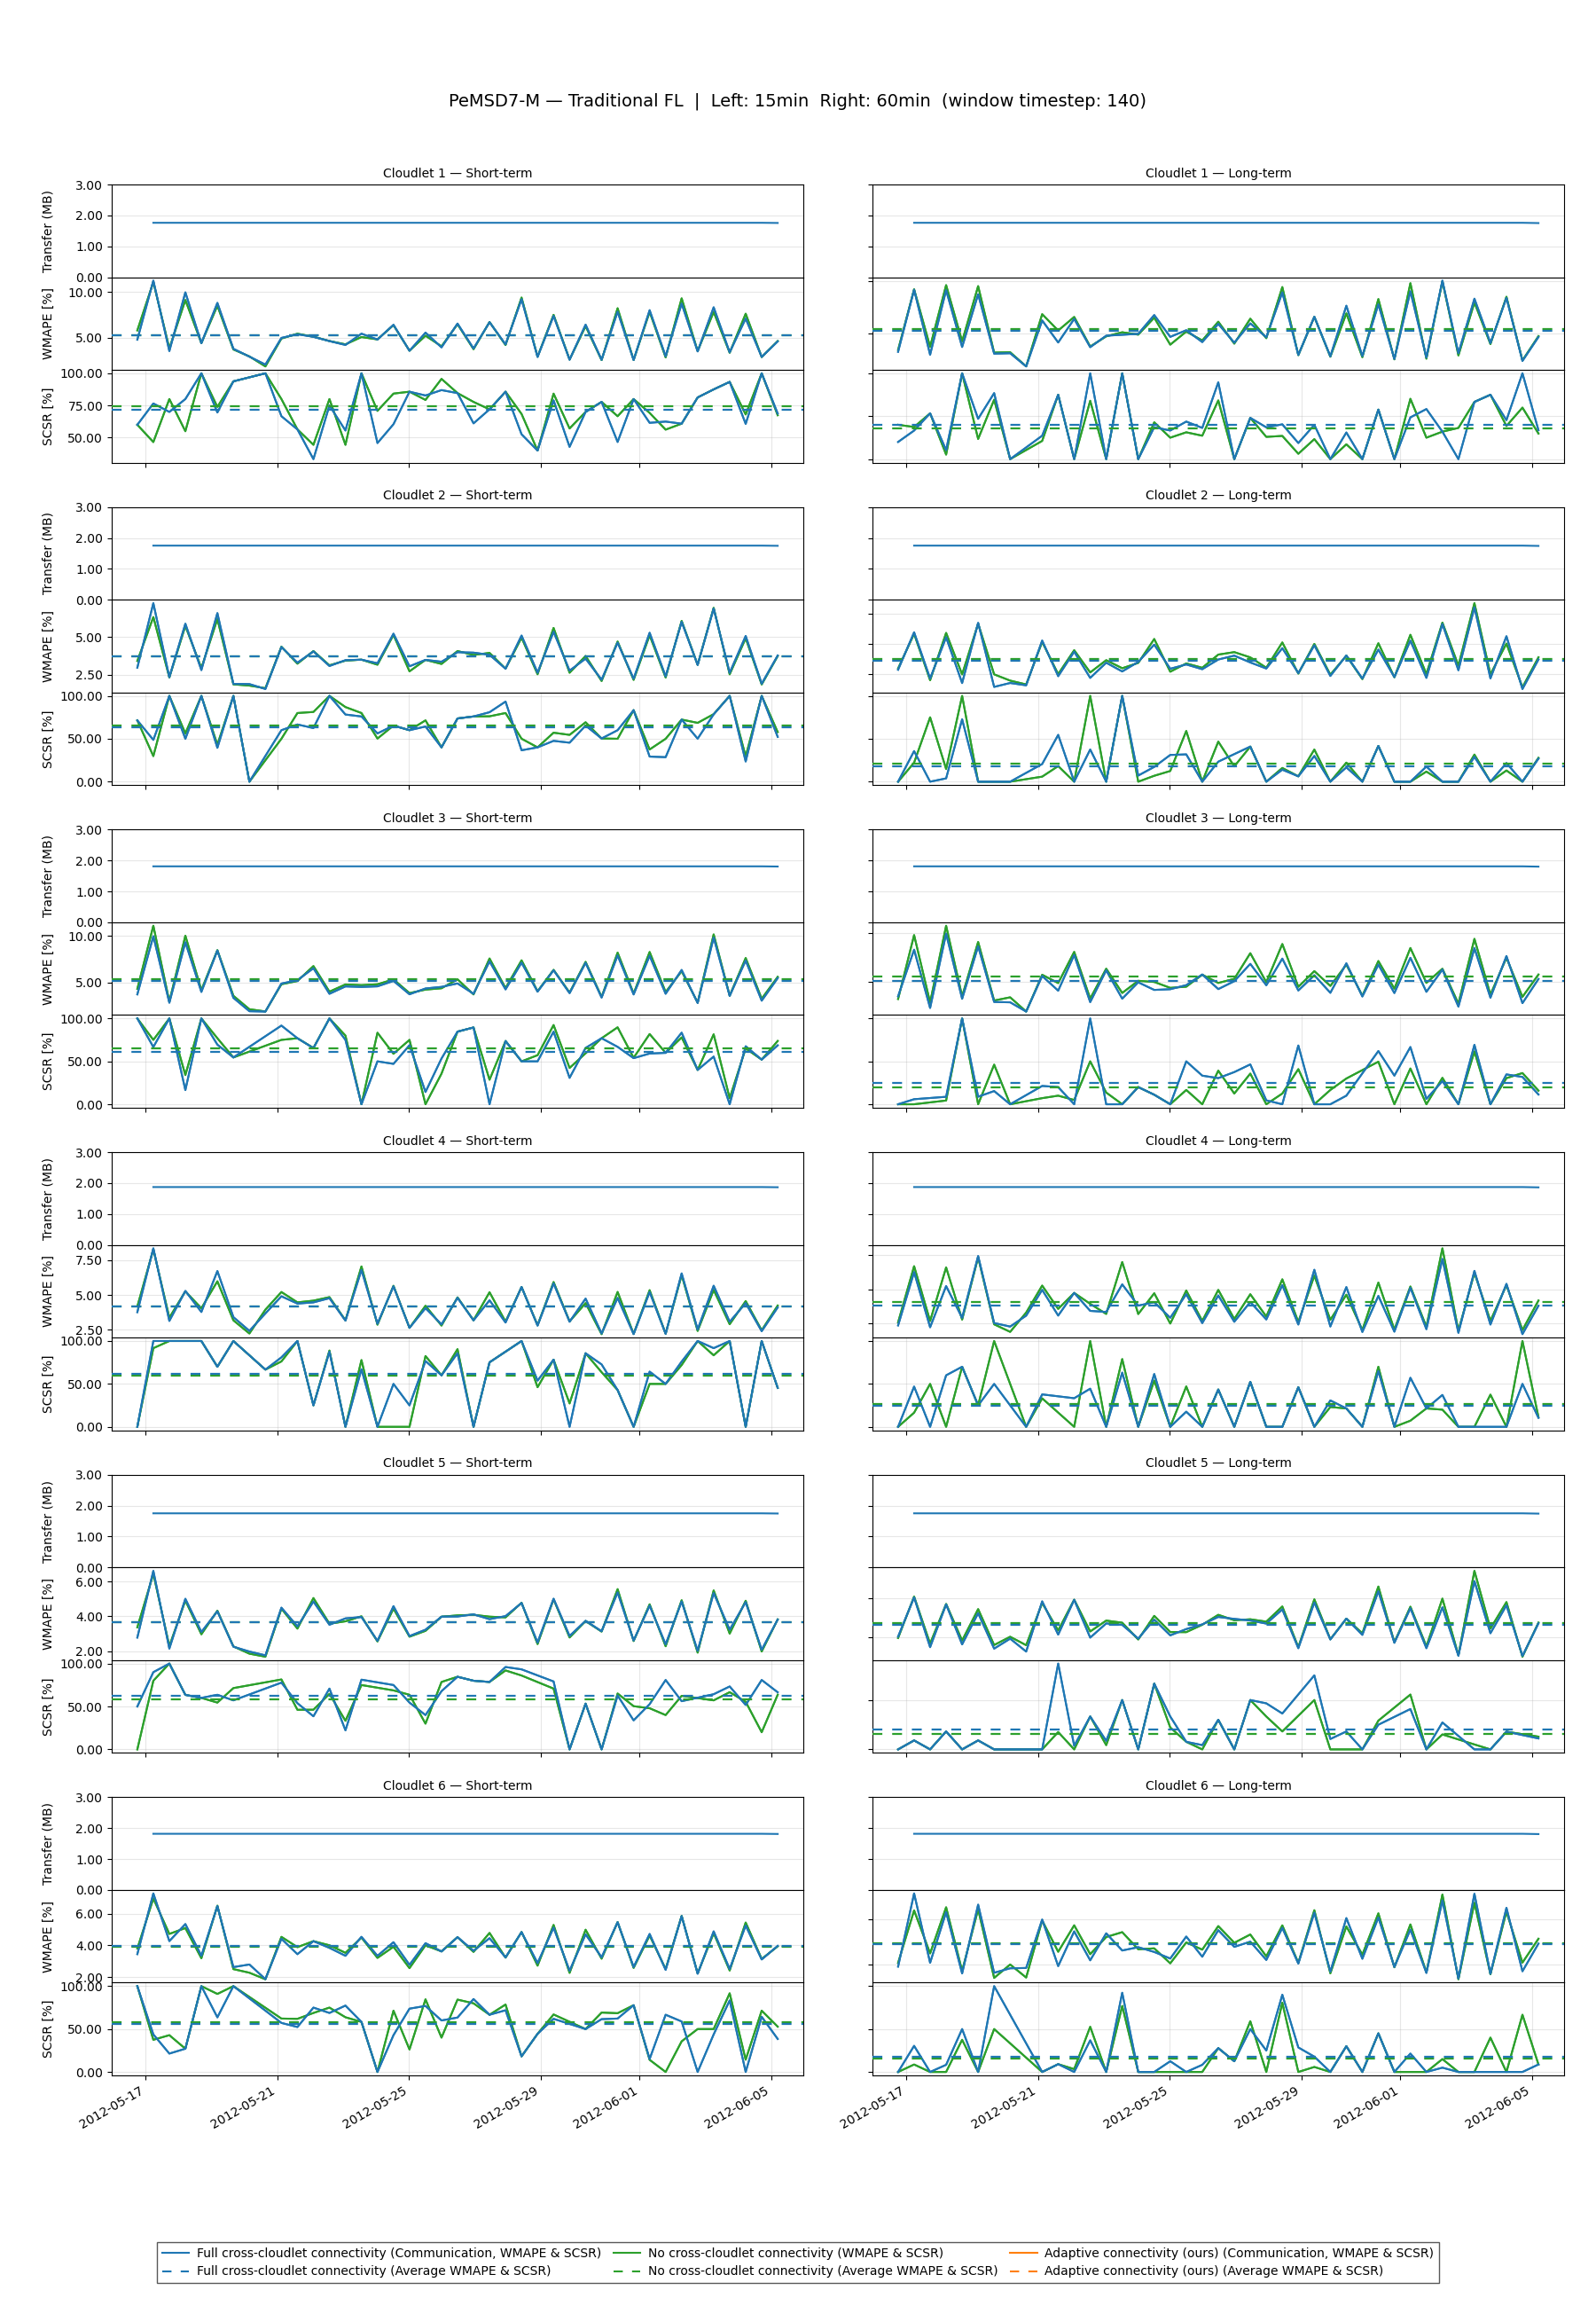

In [15]:
# pemsd7_m__trad_fl__15min__dps140__with_algorithm__log_folder = '../../logs/2025-11-11_11-29-39_pemsd7-m_pred-15min_dps-140_trad-fl-distance_online-training_no_graph_connectivity' # change later
pemsd7_m__trad_fl__15min__dps140__no_graph_connectivity__log_folder = '../../logs/2025-11-11_11-29-39_pemsd7-m_pred-15min_dps-140_trad-fl-distance_online-training_no_graph_connectivity'
pemsd7_m__trad_fl__15min__dps140__no_algorithm__log_folder = '../../logs/2025-11-11_10-50-10_pemsd7-m_pred-15min_dps-140_trad-fl-distance_online-training_no_algorithm'

pemsd7_m__plot_info__15min = {
    "dataset": "PeMSD7-M",
    "setup": "Traditional FL",
    "forecast": "15min",
    "dps": 140,
}

pemsd7_m__experiments__15min = {
    "No graph connectivity": {
        "folder": f"{pemsd7_m__trad_fl__15min__dps140__no_graph_connectivity__log_folder}",
        "data_per_step": 140
    },
    "Full graph connectivity": {
        "folder": f"{pemsd7_m__trad_fl__15min__dps140__no_algorithm__log_folder}",
        "data_per_step": 140
    },
    # "Node score algorithm": {
    #     "folder": f"{pemsd7_m__trad_fl__15min__dps140__with_algorithm__log_folder}",
    #     "data_per_step": 140
    # },
}

# pemsd7_m__trad_fl__60min__dps140__with_algorithm__log_folder = '../../logs/2025-11-11_11-29-39_pemsd7-m_pred-15min_dps-140_trad-fl-distance_online-training_no_graph_connectivity' # change later
pemsd7_m__trad_fl__60min__dps140__no_graph_connectivity__log_folder = '../../logs/2025-11-11_14-00-36_pemsd7-m_pred-60min_dps-140_trad-fl-distance_online-training_no_graph_connectivity'
pemsd7_m__trad_fl__60min__dps140__no_algorithm__log_folder = '../../logs/2025-11-11_13-21-04_pemsd7-m_pred-60min_dps-140_trad-fl-distance_online-training_no_algorithm'

pemsd7_m__plot_info__60min = {
    "dataset": "PeMSD7-M",
    "setup": "Traditional FL",
    "forecast": "60min",
    "dps": 140,
}

pemsd7_m__experiments__60min = {
    "No graph connectivity": {
        "folder": f"{pemsd7_m__trad_fl__60min__dps140__no_graph_connectivity__log_folder}",
        "data_per_step": 140
    },
    "Full graph connectivity": {
        "folder": f"{pemsd7_m__trad_fl__60min__dps140__no_algorithm__log_folder}",
        "data_per_step": 140
    },
    # "Node score algorithm": {
    #     "folder": f"{pemsd7_m__trad_fl__60min__dps140__with_algorithm__log_folder}",
    #     "data_per_step": 140
    # },
}

plot_pemsd7m_short_vs_long_tripanel(
    short_experiments=pemsd7_m__experiments__15min,   # your dict for 15min
    long_experiments=pemsd7_m__experiments__60min,    # your dict for 60min
    short_info=pemsd7_m__plot_info__15min,
    long_info=pemsd7_m__plot_info__60min,
    cloudlets_human=[1,2,3,4,5,6],
    comm_ylim=(0, 3),           # optional
    wmape_ylim=None,            # optional
    scsr_ylim=None,             # optional
    figHeight=26,
)


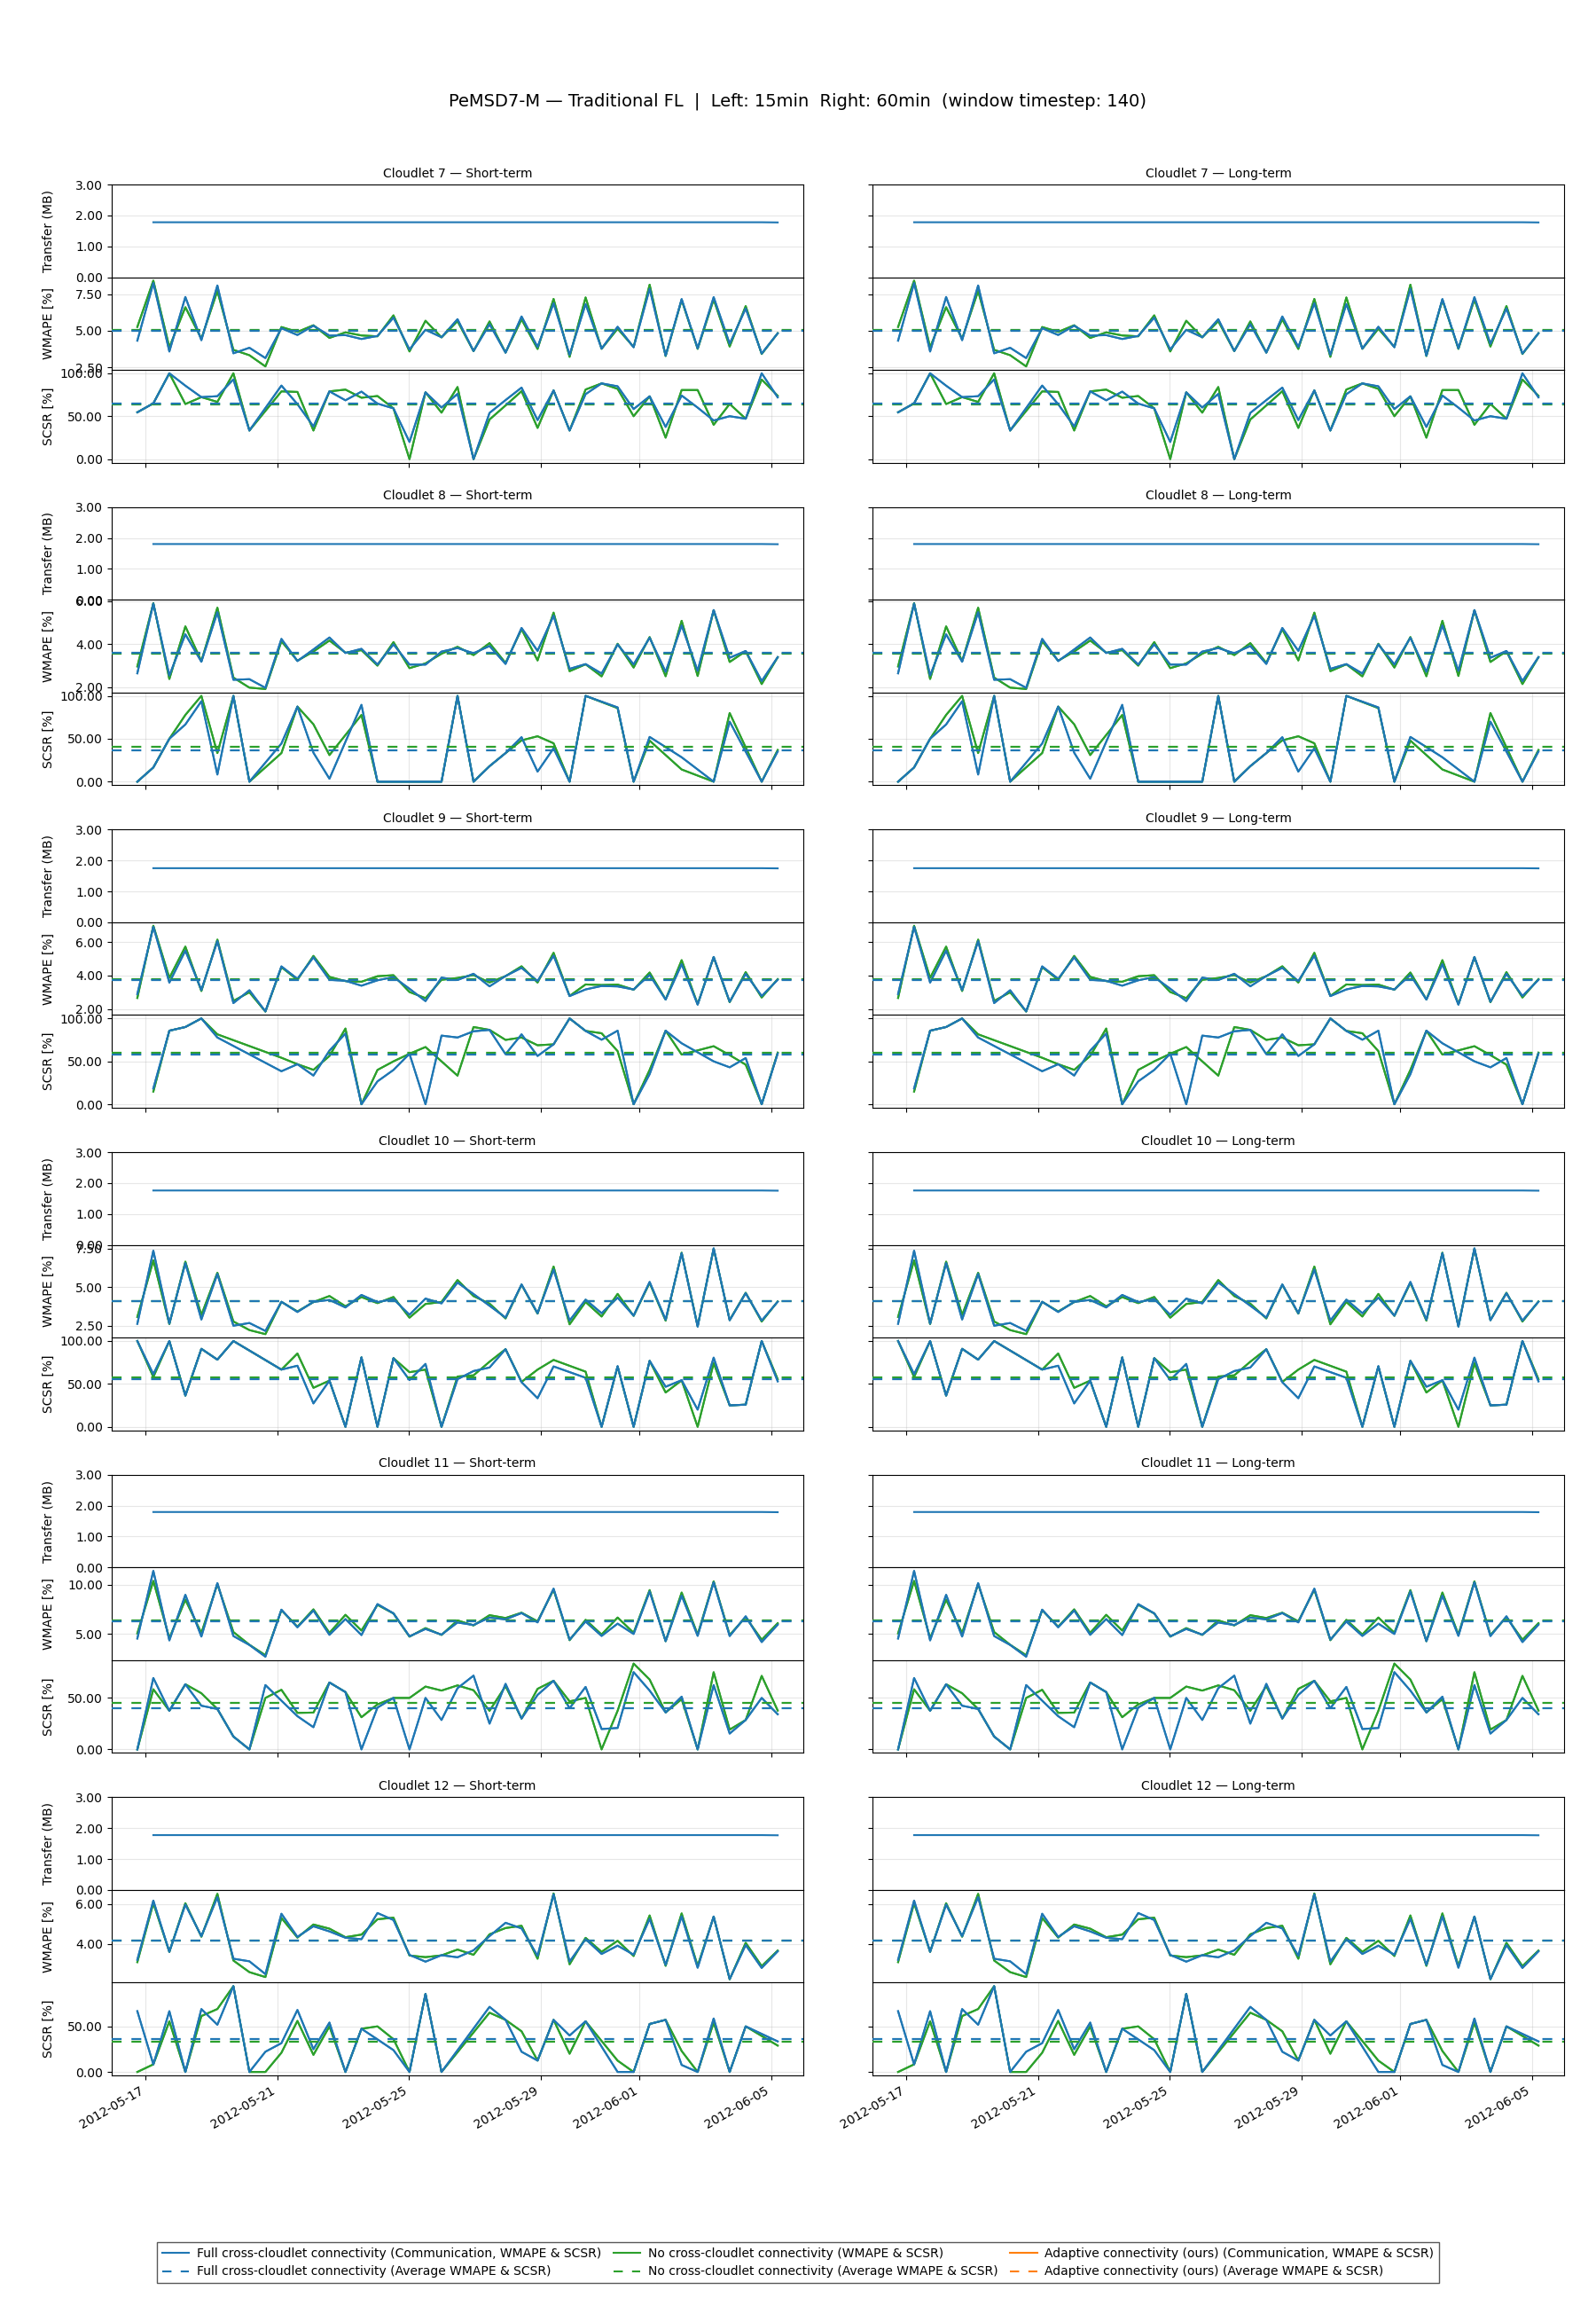

In [16]:
# pemsd7_m__trad_fl__15min__dps140__with_algorithm__log_folder = '../../logs/2025-11-11_11-29-39_pemsd7-m_pred-15min_dps-140_trad-fl-distance_online-training_no_graph_connectivity' # change later
pemsd7_m__trad_fl__15min__dps140__no_graph_connectivity__log_folder = '../../logs/2025-11-11_11-29-39_pemsd7-m_pred-15min_dps-140_trad-fl-distance_online-training_no_graph_connectivity'
pemsd7_m__trad_fl__15min__dps140__no_algorithm__log_folder = '../../logs/2025-11-11_10-50-10_pemsd7-m_pred-15min_dps-140_trad-fl-distance_online-training_no_algorithm'

pemsd7_m__plot_info__15min = {
    "dataset": "PeMSD7-M",
    "setup": "Traditional FL",
    "forecast": "15min",
    "dps": 140,
}

pemsd7_m__experiments__15min = {
    "No graph connectivity": {
        "folder": f"{pemsd7_m__trad_fl__15min__dps140__no_graph_connectivity__log_folder}",
        "data_per_step": 140
    },
    "Full graph connectivity": {
        "folder": f"{pemsd7_m__trad_fl__15min__dps140__no_algorithm__log_folder}",
        "data_per_step": 140
    },
    # "Node score algorithm": {
    #     "folder": f"{pemsd7_m__trad_fl__15min__dps140__with_algorithm__log_folder}",
    #     "data_per_step": 140
    # },
}

# pemsd7_m__trad_fl__60min__dps140__with_algorithm__log_folder = '../../logs/2025-11-11_11-29-39_pemsd7-m_pred-15min_dps-140_trad-fl-distance_online-training_no_graph_connectivity' # change later
pemsd7_m__trad_fl__60min__dps140__no_graph_connectivity__log_folder = '../../logs/2025-11-11_11-29-39_pemsd7-m_pred-15min_dps-140_trad-fl-distance_online-training_no_graph_connectivity' # change later
pemsd7_m__trad_fl__60min__dps140__no_algorithm__log_folder = '../../logs/2025-11-11_10-50-10_pemsd7-m_pred-15min_dps-140_trad-fl-distance_online-training_no_algorithm' # change later

pemsd7_m__plot_info__60min = {
    "dataset": "PeMSD7-M",
    "setup": "Traditional FL",
    "forecast": "60min",
    "dps": 140,
}

pemsd7_m__experiments__60min = {
    "No graph connectivity": {
        "folder": f"{pemsd7_m__trad_fl__60min__dps140__no_graph_connectivity__log_folder}",
        "data_per_step": 140
    },
    "Full graph connectivity": {
        "folder": f"{pemsd7_m__trad_fl__60min__dps140__no_algorithm__log_folder}",
        "data_per_step": 140
    },
    # "Node score algorithm": {
    #     "folder": f"{pemsd7_m__trad_fl__60min__dps140__with_algorithm__log_folder}",
    #     "data_per_step": 140
    # },
}

plot_pemsd7m_short_vs_long_tripanel(
    short_experiments=pemsd7_m__experiments__15min,   # your dict for 15min
    long_experiments=pemsd7_m__experiments__60min,    # your dict for 60min
    short_info=pemsd7_m__plot_info__15min,
    long_info=pemsd7_m__plot_info__60min,
    cloudlets_human=[7,8,9,10,11,12],
    comm_ylim=(0, 3),           # optional
    wmape_ylim=None,            # optional
    scsr_ylim=None,             # optional
    figHeight=26,
)
